In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

## Learnings so far
* Less injects, faster converge
* Earlier layers injects -> more rough
* Later layers injects -> more fine

In [2]:
from pathlib import Path
from fastai.basic_train import load_learner

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [5]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
style_img = image_loader("/home/jupyter/data/" + "hendrix.jpg")

style_img = style_img[:, :3, :, :512]
content_img.shape
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


In [72]:
#encode in strings
#import trained model
#run style transfer with config
#save input, output
#save config as JSON
#callback for 'run style transfer'

#serialize JSON
#product 

#vgg19_age_2.pkl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
style_img = style_img[:, :3, :, :512]
#product(styles, content)
batch_config = {
    #all relations and tweaking is assumed a cartesian product of params
    "model_path": "/home/jupyter/models/",
    "model": "vgg19_age_2.pkl", #TODO: model_meta: information about models trained...
    "loss_func": "",
    "style_content_pairs": [ #can run multiple pair, inputs
        ("/home/jupyter/data/" + "hendrix.jpg", 
         "/home/jupyter/data/" + "markus_pp.jpg"
         )
    ],
    #"optimizer": "LGTB",
    #"callback": "...",
    "style_transfer_optim_v": 0.1,
    "style_injects":[[f'conv-{i}' for i in range(5)]],
    "content_injects": [["conv-15"]],
    "style_weight": 1000000,
    "content_weight": 1,
    #['conv-5'], ['conv-4', 'conv-7'] -- was good 
    "epochs": 700,
    "save_every_x_epoch": 50, #non-linear might be better
    "tv_weight": 0.001,
    "output_path":"/home/jupyter/data/style_transfers_3/",
    "outputs": "..."
    #just sketching the output file here - not config
    #"outputs": [{"epoch": 100, img_path:"..." }]
}


In [73]:
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

In [74]:
#add %timer to params -- know how long the training took
from numpy import random
def hyperparam_traverse(config, use_noise=False, verbose=True):
    #const {id, name, x} = obj
    outpath = config["output_path"]
    #SETUP ARCH
    learner = load_learner(path = config["model_path"], file = config["model"])
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    #iteration logic later
    style_p, content_p = config["style_content_pairs"][0]
    style_img = image_loader(style_p)
    style_img = style_img[:, :3, :, :512]

    content_img = image_loader(content_p)    

    assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
    #luckily content doesn't vary...
    content_injects = config["content_injects"]
 

    #for loop here over permutations
    for content_inject in config['content_injects']:
        for style_inject in config["style_injects"]:
        
            style_module = StyleTransferModule(
            arch, 
            content_target=content_img, 
            content_layer_keys=content_inject, #TRY AGAIN WITH CONTENT 
            style_target=style_img, 
            style_layer_keys=style_inject)

                #TODO try noise instead
             #TODO try noise instead
            if use_noise: 
                input_img = torch.rand(content_img.size()).to(device)
            else:
                input_img = content_img.clone()
            # style_injects = config["style_injects"]
            folder_name = "style"
            for s in style_inject:
                folder_name += "-" + s.split("-")[1]
            folder_name += "_content"
            for c in content_inject:
                folder_name += "-" + c.split("-")[1]
            folder_name += "/"
            
            filepath = outpath + folder_name
            
            p = Path(filepath)
            print(p)
            p.mkdir(parents=True, exist_ok=True)
            conf = config.copy()
            conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
            conf["outputs"] = []
            
            conf["style_injects"] = style_inject
            conf["content_injects"] = content_inject

            def tap_closure(epoch, img, style_loss, content_loss, ):                
                
               
                if epoch % config["save_every_x_epoch"] != 0: 
                    return
                
                plt.figure()
                imshow(img, title='Output Image')
                plt.show()
                image = img.cpu().clone()  # we clone the tensor to not do changes on it
                image = image.squeeze(0)      # remove the fake batch dimension
                image = unloader(image)
                SL = str(round(style_loss))
                CL = str(round(content_loss))
                print("SL:  ", SL, "CL:  ", CL)
                fname = str(epoch) + "_SL_" + SL + "_CL_" + CL
                conf["outputs"].append({"epoch": epoch, "image": fname, "style_loss": SL, "content_loss": CL})
                image.save(p / (fname + ".jpg"), 'JPEG')

            #print(str(style_inject))
            output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], style_weight=config["style_weight"], content_weight=config["content_weight"], tv_weight=config["tv_weight"], callback=tap_closure, verbose=verbose)


            #SAVE CONFIG
            confpath = filepath + "config.json"
            
            #json.dump(conf, default=lambda o: o.__dict__, indent=4)
            with open(confpath, 'w') as outfile:
                print(confpath)
                json.dump(conf, outfile)

            plt.figure()
            imshow(output, title='Output Image')
            plt.show()

    return output 

/home/jupyter/data/style_transfers_3/style-0-1-2-3-4_content-15
Optimizing...


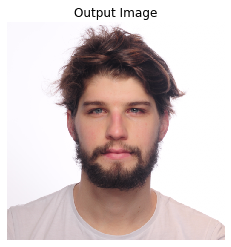

SL:   157590 CL:   0


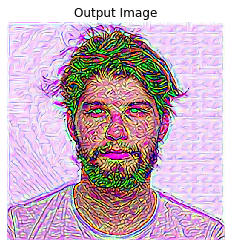

SL:   1034 CL:   7


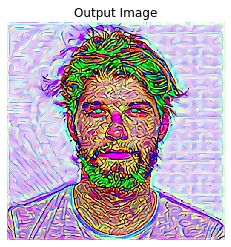

SL:   322 CL:   6


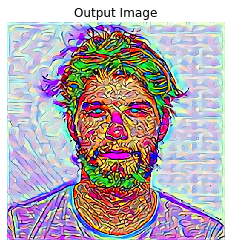

SL:   149 CL:   5


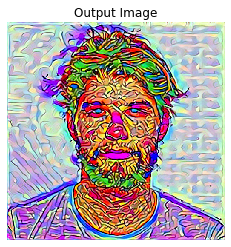

SL:   106 CL:   5


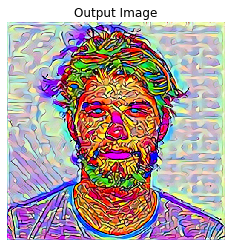

SL:   39 CL:   4


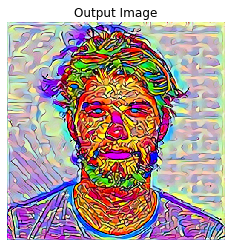

SL:   25 CL:   4


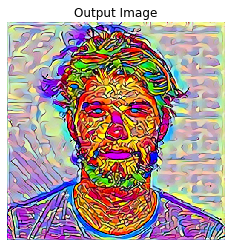

SL:   18 CL:   4


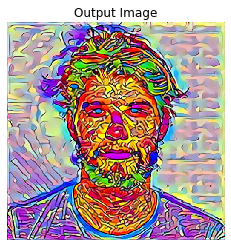

SL:   13 CL:   4


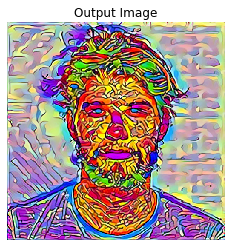

SL:   11 CL:   4


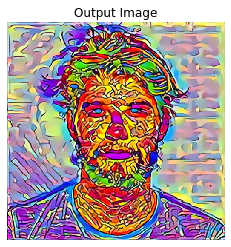

SL:   11 CL:   4


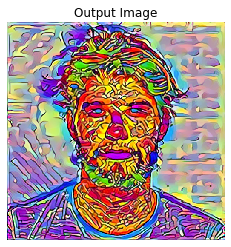

SL:   8 CL:   3


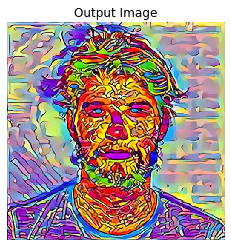

SL:   7 CL:   3


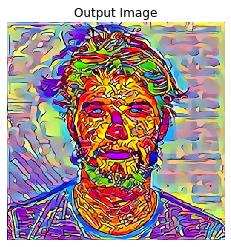

SL:   6 CL:   3


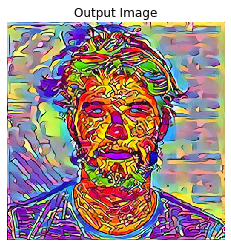

SL:   9 CL:   4
/home/jupyter/data/style_transfers_3/style-0-1-2-3-4_content-15/config.json


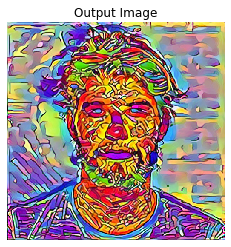

tensor([[[[0.7039, 0.7918, 0.7987,  ..., 0.9809, 0.8170, 0.8126],
          [0.7023, 0.7358, 0.7398,  ..., 0.9808, 0.8398, 0.8096],
          [0.7045, 0.7268, 0.7328,  ..., 0.9875, 0.9849, 0.9783],
          ...,
          [0.0154, 0.0166, 0.8627,  ..., 0.6307, 0.6230, 0.5196],
          [0.0132, 0.0131, 0.4825,  ..., 0.4842, 0.4762, 0.4791],
          [0.0220, 0.0183, 0.0152,  ..., 0.4578, 0.4672, 0.4735]],

         [[0.6050, 0.6100, 0.6121,  ..., 0.3510, 0.2061, 0.2059],
          [0.6054, 0.8471, 0.8834,  ..., 0.8887, 0.6552, 0.2194],
          [0.6038, 0.8564, 0.8777,  ..., 0.8914, 0.9111, 0.6704],
          ...,
          [0.1795, 0.3577, 0.3200,  ..., 0.9481, 0.9202, 0.8542],
          [0.0675, 0.0213, 0.3005,  ..., 0.5041, 0.4995, 0.5675],
          [0.0679, 0.0436, 0.1618,  ..., 0.4036, 0.4110, 0.4219]],

         [[0.8402, 0.8404, 0.8344,  ..., 0.3824, 0.4046, 0.4079],
          [0.8403, 0.8411, 0.8056,  ..., 0.3893, 0.4324, 0.4113],
          [0.8428, 0.8426, 0.8020,  ..., 0

In [69]:
hyperparam_traverse(batch_config, verbose=False)

In [70]:
batch_config["model"] = "imdb-sample-vgg19-unfr.pkl"

/home/jupyter/data/style_transfers_3/style-0-1-2-3-4_content-15
Optimizing...


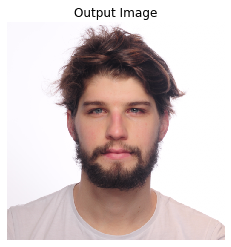

SL:   158765 CL:   0


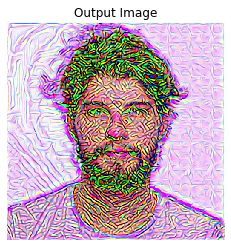

SL:   1029 CL:   6


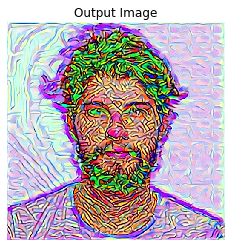

SL:   281 CL:   5


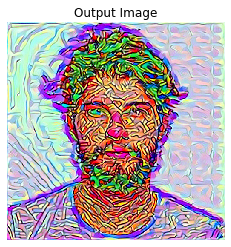

SL:   113 CL:   5


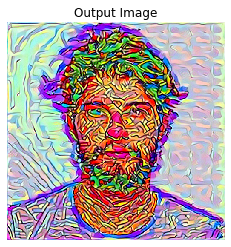

SL:   57 CL:   4


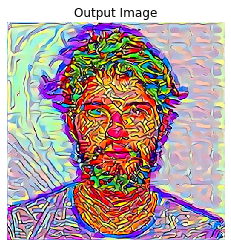

SL:   35 CL:   4


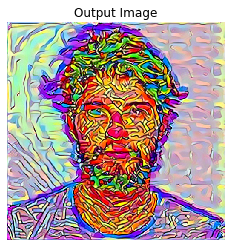

SL:   24 CL:   4


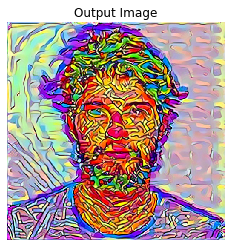

SL:   17 CL:   4


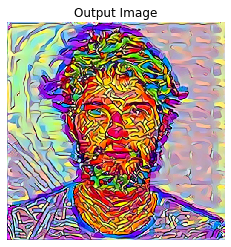

SL:   13 CL:   4


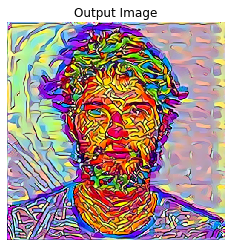

SL:   10 CL:   4


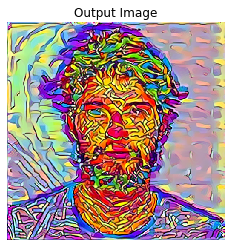

SL:   9 CL:   4


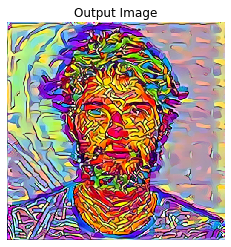

SL:   11 CL:   4


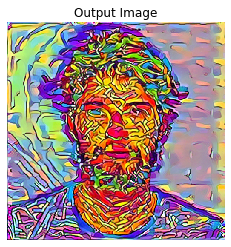

SL:   10 CL:   4


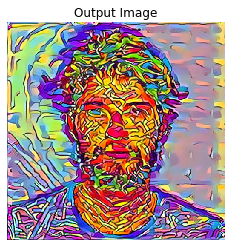

SL:   6 CL:   3


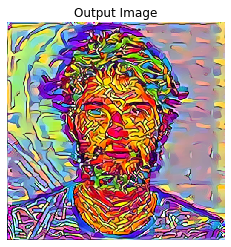

SL:   6 CL:   3
/home/jupyter/data/style_transfers_3/style-0-1-2-3-4_content-15/config.json


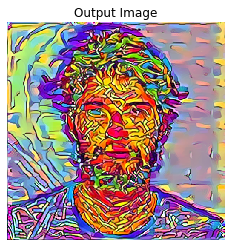

tensor([[[[3.7400e-01, 3.7445e-01, 3.8224e-01,  ..., 9.6884e-01,
           8.6800e-01, 8.2309e-01],
          [3.7457e-01, 3.7471e-01, 5.6236e-01,  ..., 9.9012e-01,
           9.0600e-01, 8.4642e-01],
          [3.9687e-01, 4.0505e-01, 6.6160e-01,  ..., 9.9045e-01,
           9.6465e-01, 9.6237e-01],
          ...,
          [2.1583e-01, 2.2190e-01, 9.6997e-01,  ..., 6.0203e-01,
           6.4716e-01, 6.4679e-01],
          [1.0277e-01, 1.0328e-01, 4.2219e-01,  ..., 5.9864e-01,
           6.2778e-01, 6.2809e-01],
          [8.6558e-02, 8.9975e-02, 8.9277e-04,  ..., 4.4544e-01,
           4.8574e-01, 4.8884e-01]],

         [[4.1685e-01, 4.1685e-01, 4.5540e-01,  ..., 8.2910e-01,
           6.2870e-02, 6.3234e-02],
          [4.1646e-01, 4.1795e-01, 9.9239e-01,  ..., 8.8073e-01,
           7.6436e-01, 6.6515e-02],
          [4.0759e-01, 6.0359e-01, 9.9825e-01,  ..., 8.8105e-01,
           8.7984e-01, 5.8949e-01],
          ...,
          [7.3254e-02, 2.3440e-01, 2.9242e-01,  ..., 8.8687

In [71]:
hyperparam_traverse(batch_config, verbose=False)

In [20]:
from itertools import product, chain, combinations, permutations
from random import sample 
conv_layer_indices = list(range(0, 16))

In [21]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

layer_combos =  [list(subs) for subs in powerset(list(range(0, 16))) if subs != () ]

In [22]:

samp = sample(layer_combos,k=1000)
samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]
samp_layers[:3]

[['conv-0',
  'conv-1',
  'conv-5',
  'conv-7',
  'conv-8',
  'conv-9',
  'conv-11',
  'conv-13'],
 ['conv-1', 'conv-2', 'conv-5', 'conv-7', 'conv-9', 'conv-13'],
 ['conv-0', 'conv-4', 'conv-6', 'conv-7', 'conv-8', 'conv-14', 'conv-15']]

/home/jupyter/data/style_transfers_3/style-0-1-5-7-8-9-11-13_content-5
Optimizing...
SL:   2264040 CL:   0
SL:   16114 CL:   234
SL:   4730 CL:   242
SL:   2359 CL:   245
SL:   1589 CL:   246
SL:   1351 CL:   246
SL:   1204 CL:   246
SL:   40571 CL:   272
SL:   5618 CL:   280
SL:   2300 CL:   281
SL:   1470 CL:   280
SL:   1032 CL:   279
SL:   913 CL:   279
/home/jupyter/data/style_transfers_3/style-0-1-5-7-8-9-11-13_content-5/config.json


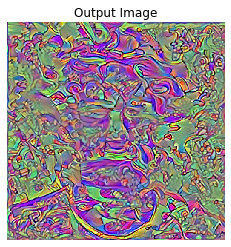

/home/jupyter/data/style_transfers_3/style-1-2-5-7-9-13_content-5
Optimizing...
SL:   1912131 CL:   0
SL:   20034 CL:   232
SL:   7622 CL:   244
SL:   2520 CL:   247
SL:   1465 CL:   247
SL:   1170 CL:   247
SL:   1014 CL:   246
SL:   894 CL:   247
SL:   181806 CL:   249
SL:   6595 CL:   256
SL:   1442 CL:   259
SL:   837 CL:   258
SL:   632 CL:   258
/home/jupyter/data/style_transfers_3/style-1-2-5-7-9-13_content-5/config.json


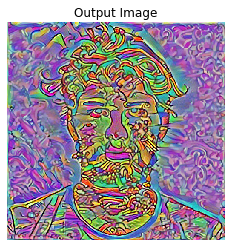

/home/jupyter/data/style_transfers_3/style-0-4-6-7-8-14-15_content-5
Optimizing...
SL:   2125602 CL:   0
SL:   14350 CL:   226
SL:   2735 CL:   231
SL:   1271 CL:   234
SL:   904 CL:   235
SL:   802 CL:   235
SL:   779 CL:   235
SL:   643 CL:   235
SL:   49662 CL:   254
SL:   2640 CL:   242
SL:   1185 CL:   243
SL:   733 CL:   243
SL:   593 CL:   242
/home/jupyter/data/style_transfers_3/style-0-4-6-7-8-14-15_content-5/config.json


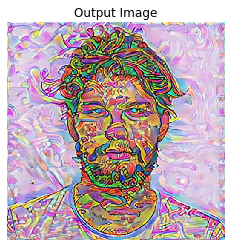

/home/jupyter/data/style_transfers_3/style-5-6-7-12-15_content-5
Optimizing...
SL:   1909696 CL:   0
SL:   12660 CL:   240


In [ ]:
bc = batch_config.copy()
samp
bc["style_injects"] = samp_layers
hyperparam_traverse(bc, verbose=False)